## Expand and visualize dictionaries

Computational Literature Review

Creator: Jaren Haber, PhD Candidate, Nancy Xu

Date created: February 20, 2022

Date last modified: April 11, 2022

This notebook expand the seed dictionaries for each perspectives over 4 decades, and visualize them with TSNE. 

In [1]:
# IMPORTING KEY PACKAGES
import gensim # for word embedding models
import _pickle as cPickle # Optimized version of pickle
import gc # For managing garbage collector
from collections import Counter # For counting terms across the corpus
import re # For filtering most_similar() output--remove surnames
import csv # For saving csv files
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pandas as pd

In [2]:
def dict_cohere(thisdict, wem_model):
    '''Computes the average cosine similarity score of terms within one dictionary with all other terms in that same dictionary,
    effectively measuring the coherence of the dictionary.
    ...question for development: does it make sense to compare the average cosine similarity score between all terms 
    in thisdict and the average cosine similarity among the total model vocabulary? (Could that be, by definition, 0?)
    
    NOTE: For an unknown reason, calling this function deletes terms from thisdict.
    
    Inputs: List of key terms, word2vec model.
    Output: Average cosine similarity score of each word with all other words in the list of key terms.'''
    
    # Initialize average distance variables:
    word_avg_dist = 0
    word_avg_dists = 0
    dict_avg_sim = 0
    all_avg_dists = 0
    model_avg_dists = 0
    
    # Compute average cosine similarity score of each word with other dict words:
    for word in thisdict:
        word_avg_dist = (wem_model.wv.distances(word, other_words=thisdict).sum())/len(thisdict) # Total diffs of word with all other words, take average
        word_avg_dists += word_avg_dist # Add up each average distance, incrementally
    dict_avg_sim = 1 - word_avg_dists/len(thisdict) # Find average cosine similarity score by subtracting avg. distance from 1

    #print("Dictionary coherence (avg. cosine similarity): " + str(dict_avg_sim))
    
    return dict_avg_sim

## load models and seed lists

In [12]:
wem_path1 = 'word2vec_phrased_filtered_enchant_300d_1970_1979_2022_mar29.bin'
wem_path2 = 'word2vec_phrased_filtered_enchant_300d_1980_1989_2022_apr4.bin'
wem_path3 = 'word2vec_phrased_filtered_enchant_300d_1990_1999_2022_apr4.bin'
wem_path4 = 'word2vec_phrased_filtered_enchant_300d_2000_2016_2022_apr4.bin'


In [13]:
m1 = gensim.models.KeyedVectors.load(wem_path1)
m2 = gensim.models.KeyedVectors.load(wem_path2)
m3 = gensim.models.KeyedVectors.load(wem_path3)
m4 = gensim.models.KeyedVectors.load(wem_path4)

In [14]:
m2.wv.most_similar('population_ecology')

[('evolutionary_change', 0.47285425662994385),
 ('categorizes_organizations', 0.44014158844947815),
 ('community_ecology', 0.43649324774742126),
 ('gradualism', 0.4302196502685547),
 ('structural_inertia', 0.4280708432197571),
 ('natural_selection', 0.4223175644874573),
 ('ecology_sills', 0.42101842164993286),
 ('overcomes_limitations', 0.4157083034515381),
 ('populations', 0.4128006100654602),
 ('confederate_collective', 0.41102784872055054)]

In [15]:
m3.wv.most_similar('natural_selection')

[('manly', 0.4901719391345978),
 ('selection_retention', 0.3871505856513977),
 ('recruitment_attrition', 0.3547898232936859),
 ('technical_report', 0.34814679622650146),
 ('origin_species', 0.3444347381591797),
 ('footnotes_organizational', 0.34242546558380127),
 ('organizational_populations', 0.33705347776412964),
 ('probability_takeovers', 0.33700454235076904),
 ('groups_specialize', 0.3302328884601593),
 ('institute_inc', 0.31988370418548584)]

In [16]:
m4.wv.most_similar('board_directors')

[('recommendations_modernizing', 0.3938560485839844),
 ('debs', 0.37737661600112915),
 ('boards', 0.3718407452106476),
 ('directors', 0.36544114351272583),
 ('winning_seats', 0.36355137825012207),
 ('artistic_director', 0.3632684051990509),
 ('board', 0.3623591661453247),
 ('appoints', 0.36109858751296997),
 ('reelected_every', 0.35725411772727966),
 ('disclosure_strengthening', 0.3537522852420807)]

In [17]:
# opening the file in read mode
my_file = open("cultural_core.txt", "r")
# reading the file
data = my_file.read()
# replacing end splitting the text 
# when newline ('\n') is seen.
cult_seed_lst = data.split("\n")
my_file.close()

In [18]:
# opening the file in read mode
my_file = open("demographic_core.txt", "r")
# reading the file
data = my_file.read()
# replacing end splitting the text 
# when newline ('\n') is seen.
demog_seed_lst = data.split("\n")
my_file.close()

In [19]:
# opening the file in read mode
my_file = open("relational_core.txt", "r")
# reading the file
data = my_file.read()
# replacing end splitting the text 
# when newline ('\n') is seen.
rela_seed_lst = data.split("\n")
my_file.close()

In [20]:
cult_seed_lst1 = cult_seed_lst.copy()
cult_seed_lst2 = cult_seed_lst.copy()
cult_seed_lst3 = cult_seed_lst.copy()
cult_seed_lst4 = cult_seed_lst.copy()


demog_seed_lst1 = demog_seed_lst.copy()
demog_seed_lst2 = demog_seed_lst.copy()
demog_seed_lst3 = demog_seed_lst.copy()
demog_seed_lst4 = demog_seed_lst.copy()


rela_seed_lst1 = rela_seed_lst.copy()
rela_seed_lst2 = rela_seed_lst.copy()
rela_seed_lst3 = rela_seed_lst.copy()
rela_seed_lst4 = rela_seed_lst.copy()


In [21]:
my_file = open("surnames.txt", "r")
# reading the file
data = my_file.read()
# replacing end splitting the text 
# when newline ('\n') is seen.
surnames = data.split(",")
surnames = [i.replace("'", '').strip() for i in surnames]
my_file.close()

## remove vocab in seed vocab 

In [22]:
def remove_terms(seed_lst, m):
    for i in range(5):
        for word in seed_lst:
            try: 
                if m.wv.key_to_index[word] > 0:
#                     print('in vocab')
                    pass
            except:
                    seed_lst.remove(word)
                    print("Removed " + str(word) + " from demog dictionary.")
        # Repeat for quality (second pass sometimes catches more):
        for word in seed_lst:
            try: 
                if m.wv.key_to_index[word] > 0:
                    pass
#                     print('in vocab')
            except:
                    seed_lst.remove(word)
                    print("Removed " + str(word) + " from demog dictionary.")

    #     Remove surnames in culture
        for word in seed_lst:
            if word in surnames:
                seed_lst.remove(word)
                print("Removed " + str(word) + " from demog dictionary.")

    print("Length of culture dictionary filtered into vector space:", len(seed_lst))
    return seed_lst

In [23]:
cult_seed_lst1 = remove_terms(cult_seed_lst1, m1)
demog_seed_lst1 = remove_terms(demog_seed_lst1, m1)
rela_seed_lst1 = remove_terms(rela_seed_lst1, m1)

Removed ceremonial from demog dictionary.
Removed decouple from demog dictionary.
Removed imitate from demog dictionary.
Removed interorganizational_field from demog dictionary.
Removed isomorphism from demog dictionary.
Removed legitimation from demog dictionary.
Removed mimetic from demog dictionary.
Removed organizational_field from demog dictionary.
Removed socially_constructed from demog dictionary.
Removed decoupled from demog dictionary.
Removed imitation from demog dictionary.
Removed isomorphic from demog dictionary.
Removed structuration from demog dictionary.
Length of culture dictionary filtered into vector space: 23
Removed age_dependence from demog dictionary.
Removed carrying_capacity from demog dictionary.
Removed death_rate from demog dictionary.
Removed failure_rate from demog dictionary.
Removed founding_rate from demog dictionary.
Removed generalist from demog dictionary.
Removed inertial from demog dictionary.
Removed legitimation from demog dictionary.
Removed nat

In [25]:
cult_seed_lst2 = remove_terms(cult_seed_lst2, m2)
demog_seed_lst2 = remove_terms(demog_seed_lst2, m2)
rela_seed_lst2 = remove_terms(rela_seed_lst2, m2)

Removed interorganizational_field from demog dictionary.
Removed isomorphism from demog dictionary.
Removed legitimation from demog dictionary.
Removed organizational_field from demog dictionary.
Removed structuration from demog dictionary.
Length of culture dictionary filtered into vector space: 31
Removed birth_rate from demog dictionary.
Removed chance_survival from demog dictionary.
Removed failure_rate from demog dictionary.
Removed generalism from demog dictionary.
Removed legitimation from demog dictionary.
Removed organizational_form from demog dictionary.
Removed size_dependence from demog dictionary.
Removed survival_chance from demog dictionary.
Removed fitness from demog dictionary.
Length of culture dictionary filtered into vector space: 27
Removed coalition from demog dictionary.
Removed coopt from demog dictionary.
Removed director_interlock from demog dictionary.
Removed joint_venture from demog dictionary.
Removed power from demog dictionary.
Removed cooptation from de

In [26]:
cult_seed_lst3 = remove_terms(cult_seed_lst3, m3)
demog_seed_lst3 = remove_terms(demog_seed_lst3, m3)
rela_seed_lst3 = remove_terms(rela_seed_lst3, m3)

Removed interorganizational_field from demog dictionary.
Removed isomorphism from demog dictionary.
Removed legitimation from demog dictionary.
Removed organizational_field from demog dictionary.
Removed structuration from demog dictionary.
Length of culture dictionary filtered into vector space: 31
Removed birth_rate from demog dictionary.
Removed chance_survival from demog dictionary.
Removed fitness from demog dictionary.
Removed generalism from demog dictionary.
Removed legitimation from demog dictionary.
Removed organizational_form from demog dictionary.
Removed resistance_change from demog dictionary.
Removed size_dependence from demog dictionary.
Removed survival_chance from demog dictionary.
Length of culture dictionary filtered into vector space: 27
Removed coalition from demog dictionary.
Removed coopt from demog dictionary.
Removed power from demog dictionary.
Removed cooptation from demog dictionary.
Length of culture dictionary filtered into vector space: 32


In [27]:
cult_seed_lst4 = remove_terms(cult_seed_lst4, m4)
demog_seed_lst4 = remove_terms(demog_seed_lst4, m4)
rela_seed_lst4 = remove_terms(rela_seed_lst4, m4)

Removed interorganizational_field from demog dictionary.
Removed isomorphism from demog dictionary.
Removed legitimation from demog dictionary.
Removed organizational_field from demog dictionary.
Removed structuration from demog dictionary.
Length of culture dictionary filtered into vector space: 31
Removed birth_rate from demog dictionary.
Removed chance_survival from demog dictionary.
Removed fitness from demog dictionary.
Removed generalism from demog dictionary.
Removed legitimation from demog dictionary.
Removed natural_selection from demog dictionary.
Removed organizational_form from demog dictionary.
Removed resistance_change from demog dictionary.
Removed size_dependence from demog dictionary.
Removed survival_chance from demog dictionary.
Removed specialism from demog dictionary.
Length of culture dictionary filtered into vector space: 25
Removed coalition from demog dictionary.
Removed coopt from demog dictionary.
Removed power from demog dictionary.
Removed cooptation from d

## expand & save dictionaries

Get the closest 10, 30, and 50 terms for each set of seed terms for each time-specific embedding model.

In [28]:
top_50_demog1 = [i[0] for i in m1.wv.most_similar(demog_seed_lst1, topn = 50)]
top_50_rela1 = [i[0] for i in m1.wv.most_similar(rela_seed_lst1, topn = 50)]
top_50_cult1 = [i[0] for i in m1.wv.most_similar(cult_seed_lst1, topn = 50)]

top_50_demog2 = [i[0] for i in m2.wv.most_similar(demog_seed_lst2, topn = 50)]
top_50_rela2 = [i[0] for i in m2.wv.most_similar(rela_seed_lst2, topn = 50)]
top_50_cult2 = [i[0] for i in m2.wv.most_similar(cult_seed_lst2, topn = 50)]

top_50_demog3 = [i[0] for i in m3.wv.most_similar(demog_seed_lst3, topn = 50)]
top_50_rela3 = [i[0] for i in m3.wv.most_similar(rela_seed_lst3, topn = 50)]
top_50_cult3 = [i[0] for i in m3.wv.most_similar(cult_seed_lst3, topn = 50)]

top_50_demog4 = [i[0] for i in m4.wv.most_similar(demog_seed_lst4, topn = 50)]
top_50_rela4 = [i[0] for i in m4.wv.most_similar(rela_seed_lst4, topn = 50)]
top_50_cult4 = [i[0] for i in m4.wv.most_similar(cult_seed_lst4, topn = 50)]

In [ ]:
def write_to_csv(list_of_emails, name):
    with open(name, 'w') as csvfile:
        for domain in list_of_emails:
            csvfile.write(domain + '\n')

# write_to_csv(top_50_demog, 'closest_demog_50.csv')

In [ ]:
write_to_csv(top_50_rela1, 'closest_rela_50_1970-1979.csv')
write_to_csv(top_50_cult1, 'closest_cult_50_1970-1979.csv')
write_to_csv(top_50_demog1, 'closest_demog_50_1970-1979.csv')
write_to_csv(top_50_demog1[:30], 'closest_demog_30_1970-1979.csv')
write_to_csv(top_50_rela1[:30], 'closest_rela_30_1970-1979.csv')
write_to_csv(top_50_cult1[:30], 'closest_cult_30_1970-1979.csv')
write_to_csv(top_50_demog1[:10], 'closest_demog_10_1970-1979.csv')
write_to_csv(top_50_rela1[:10], 'closest_rela_10_1970-1979.csv')
write_to_csv(top_50_cult1[:10], 'closest_cult_10_1970-1979.csv')

write_to_csv(top_50_rela2, 'closest_rela_50_1980-1989.csv')
write_to_csv(top_50_cult2, 'closest_cult_50_1980-1989.csv')
write_to_csv(top_50_demog2, 'closest_demog_50_1980-1989.csv')
write_to_csv(top_50_demog2[:30], 'closest_demog_30_1980-1989.csv')
write_to_csv(top_50_rela2[:30], 'closest_rela_30_1980-1989.csv')
write_to_csv(top_50_cult2[:30], 'closest_cult_30_1980-1989.csv')
write_to_csv(top_50_demog2[:10], 'closest_demog_10_1980-1989.csv')
write_to_csv(top_50_rela2[:10], 'closest_rela_10_1980-1989.csv')
write_to_csv(top_50_cult2[:10], 'closest_cult_10_1980-1989.csv')

write_to_csv(top_50_rela3, 'closest_rela_50_1990-1999.csv')
write_to_csv(top_50_cult3, 'closest_cult_50_1990-1999.csv')
write_to_csv(top_50_demog3, 'closest_demog_50_1990-1999.csv')
write_to_csv(top_50_demog3[:30], 'closest_demog_30_1990-1999.csv')
write_to_csv(top_50_rela3[:30], 'closest_rela_30_1990-1999.csv')
write_to_csv(top_50_cult3[:30], 'closest_cult_30_1990-1999.csv')
write_to_csv(top_50_demog3[:10], 'closest_demog_10_1990-1999.csv')
write_to_csv(top_50_rela3[:10], 'closest_rela_10_1990-1999.csv')
write_to_csv(top_50_cult3[:10], 'closest_cult_10_1990-1999.csv')

write_to_csv(top_50_rela3, 'closest_rela_50_2000-2016.csv')
write_to_csv(top_50_cult3, 'closest_cult_50_2000-2016.csv')
write_to_csv(top_50_demog3, 'closest_demog_50_2000-2016.csv')
write_to_csv(top_50_demog3[:30], 'closest_demog_30_2000-2016.csv')
write_to_csv(top_50_rela3[:30], 'closest_rela_30_2000-2016.csv')
write_to_csv(top_50_cult3[:30], 'closest_cult_30_2000-2016.csv')
write_to_csv(top_50_demog3[:10], 'closest_demog_10_2000-2016.csv')
write_to_csv(top_50_rela3[:10], 'closest_rela_10_2000-2016.csv')
write_to_csv(top_50_cult3[:10], 'closest_cult_10_2000-2016.csv')

## TSNE visualization of seed terms + related terms

In [29]:
import numpy as np
from scipy.spatial import distance
from sklearn.manifold import TSNE
import seaborn as sns # To make matplotlib prettier
sns.set(style='white')
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # For visualizing word embeddings
from scipy.spatial import distance # To use cosine distances for tSNE metric

# Visualization parameters
%pylab inline 
%matplotlib inline


def display_closestwords(wem_model, word, plotnumber):
    '''Use tSNE to display a spatial map (i.e., scatterplot) of words vectors close to given word in Word2Vec model.
    Projects each word to a 2D space (a reduction from model size) and plots the position of each word with a label.
    Based on this blog: 
    https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)
    
    TO DO: Incorporate bold seed terms, OPTION for getting most similar words
    
    Args:
        Word2Vec model
        Input word
        Number of words to plot
    Returns:
        Visualization of relationships between given word and its closest word vectors
    '''
    
    dimensions = 300
    
    arr = np.empty((0,dimensions), dtype='f')
    word_labels = [word]

    # get close words
    close_words = wem_model.wv.most_similar(word, topn=plotnumber)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([wem_model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = wem_model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    sns.set(style='whitegrid')
    
    # display scatter plot
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(x_coords, y_coords, alpha=1, color='b')

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)
    plt.xlim(x_coords.min()+10, x_coords.max()+10)
    plt.ylim(y_coords.min()+10, y_coords.max()+10)
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [43]:
def plot_tsne(core_words, close_words, m, perspective, years):
    dimensions = 300
    arr = np.empty((0,dimensions), dtype='f')
    word_labels = []

    # add the vector for each of the closest words to the array
    for wrd_label in close_words:
        wrd_vector = m.wv[wrd_label]
        word_labels.append(wrd_label)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions, using cosine distances as metric
    tsne = TSNE(n_components=2, random_state=0, metric=distance.cosine)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(x_coords, y_coords, alpha=1, color='b')

    sns.set(style='white')

    for label, x, y in zip(word_labels, x_coords, y_coords):
        if label in core_words:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontweight='bold').set_fontsize(20)
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points').set_fontsize(20)

    ax.set_xlim(x_coords.min()-5, x_coords.max()+5)
    ax.set_ylim(y_coords.min()-5, y_coords.max()+5)
    ax.set_xlabel('t-SNE dimension 1')
    ax.set_ylabel('t-SNE dimension 2')
    ax.xaxis.label.set_fontsize(24)
    ax.yaxis.label.set_fontsize(24)
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(16)
    plt.title('Visualization of ' + perspective +' Seed Terms and Related Terms ' + years)
    plt.show()

## 1970 - 1979rela_seed_lst1

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


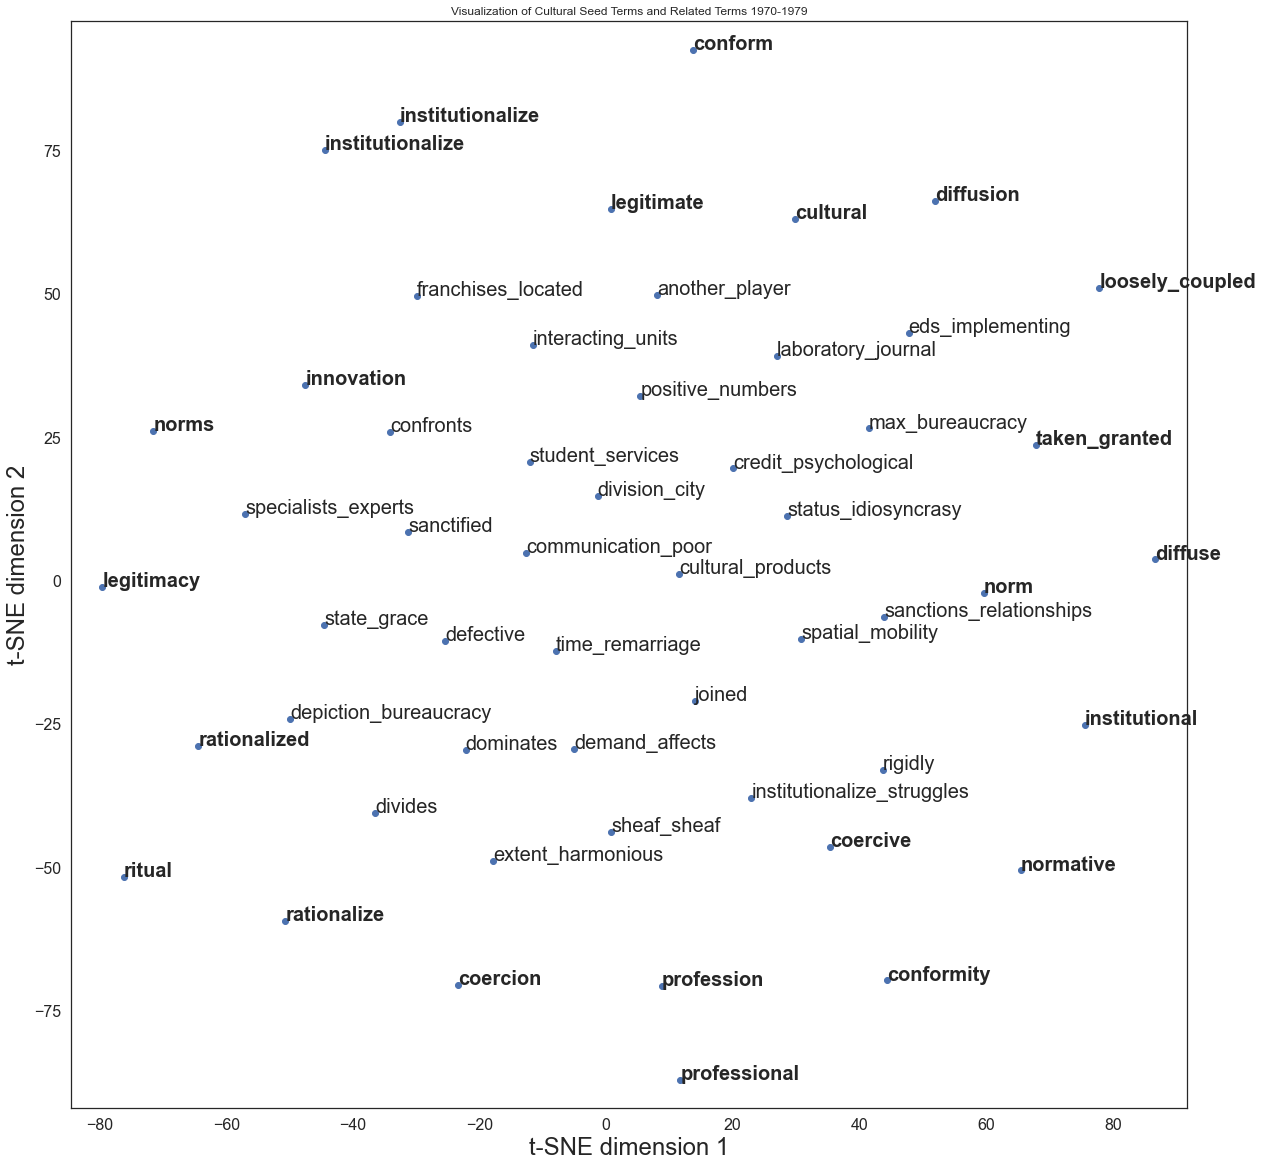

In [44]:
plot_tsne(cult_seed_lst1, cult_seed_lst1 + top_50_cult1[:30], m1, 'Cultural', '1970-1979')



/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


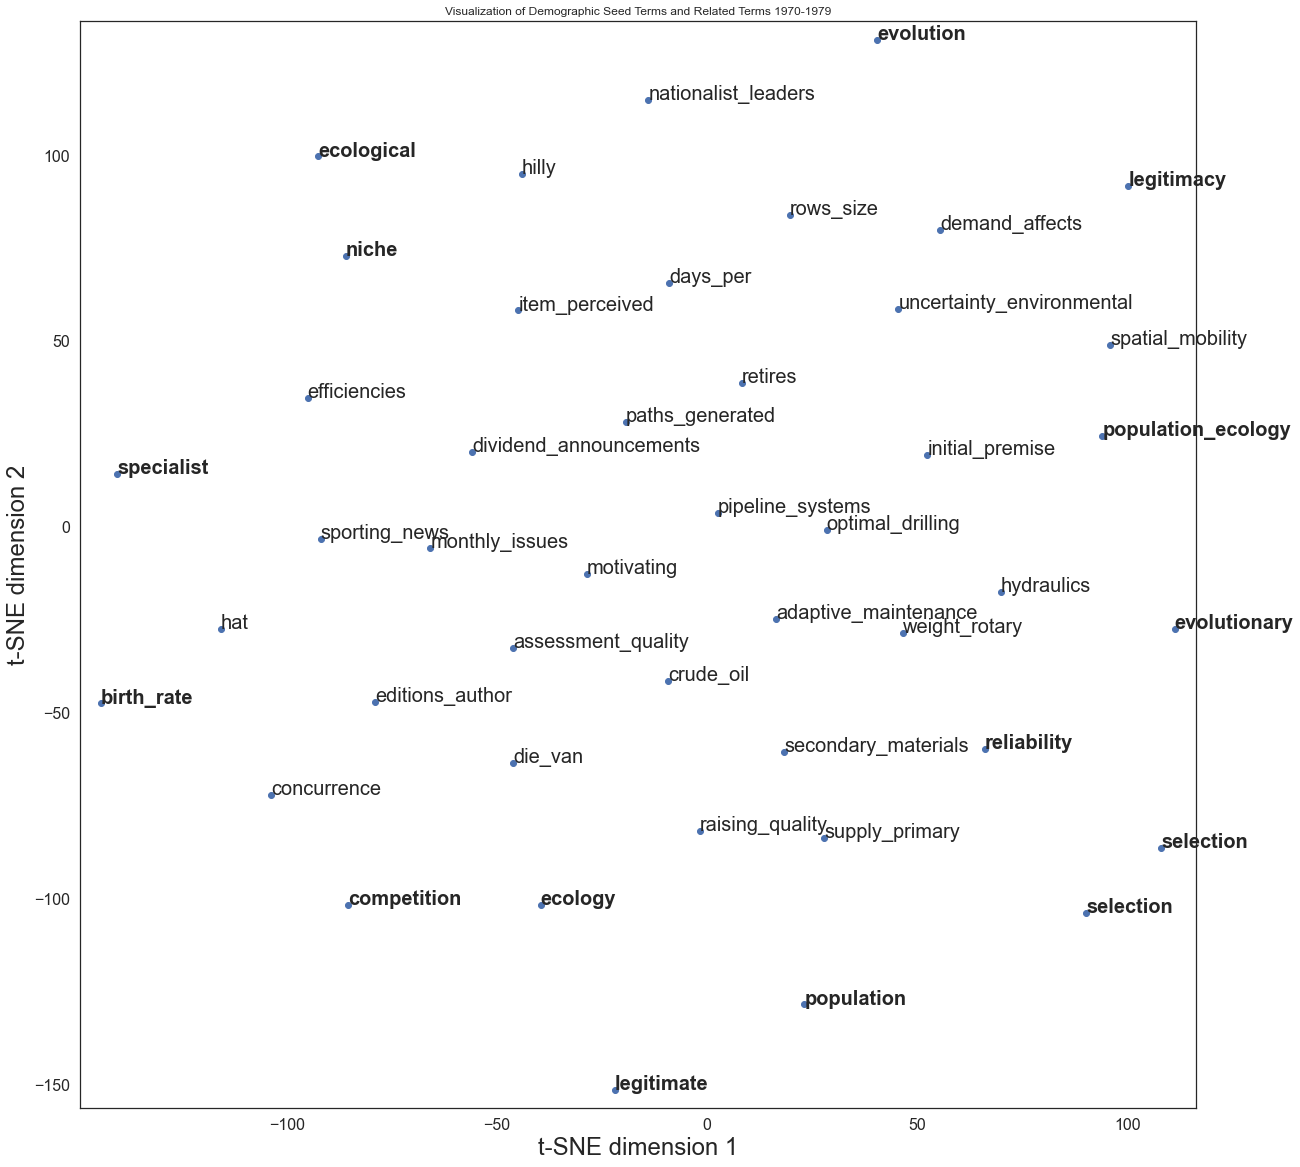

In [45]:
plot_tsne(demog_seed_lst1, demog_seed_lst1 + top_50_demog1[:30], m1, 'Demographic', '1970-1979')



/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


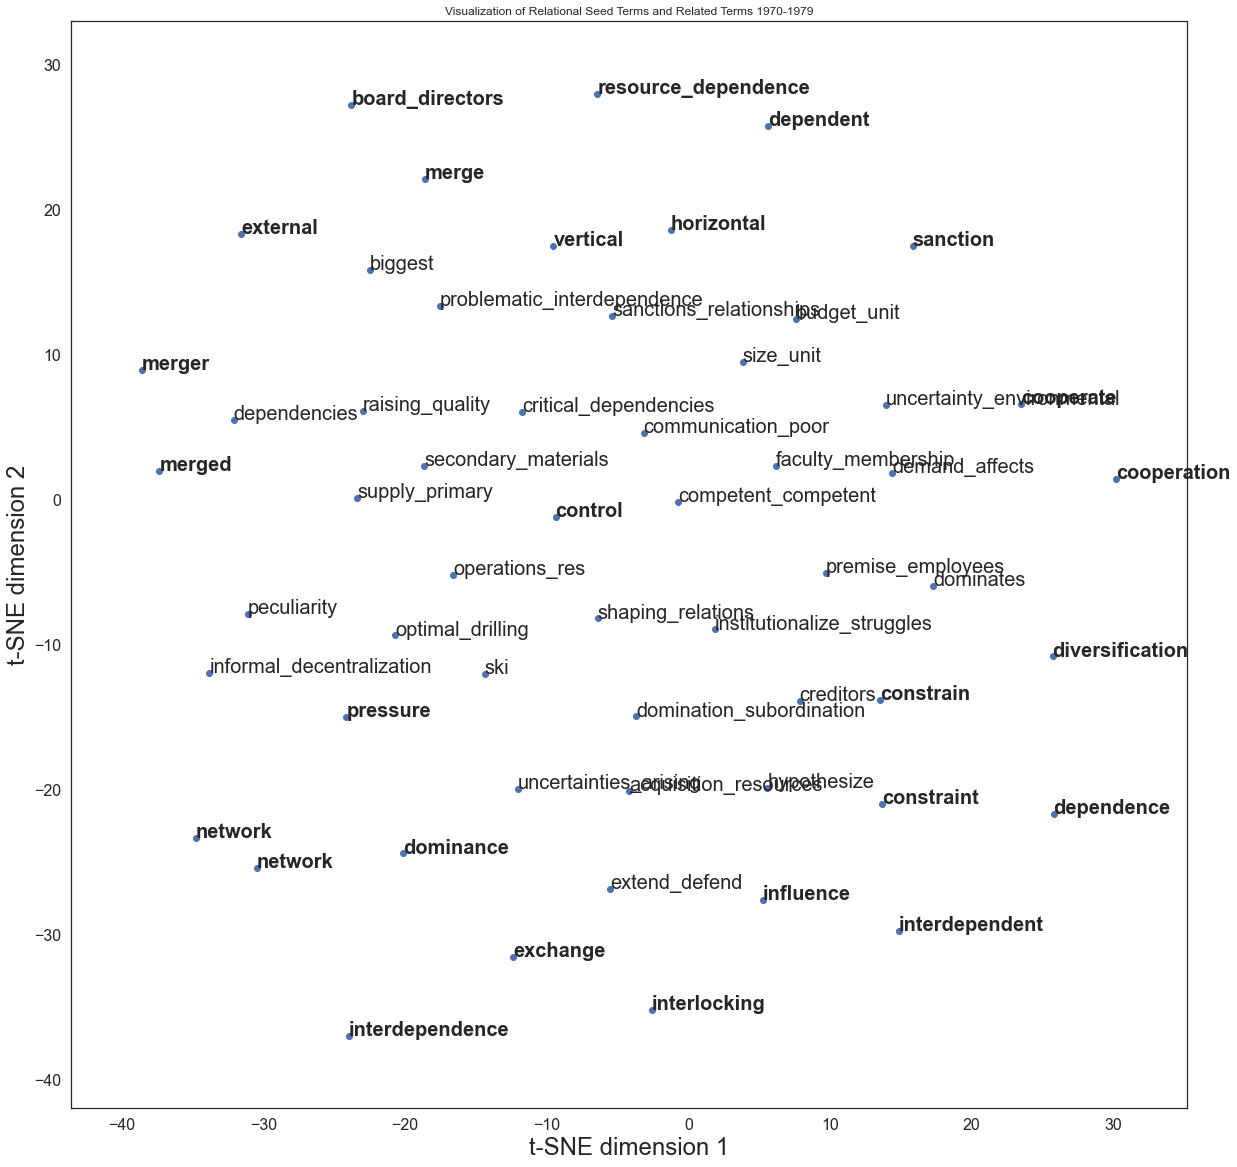

In [46]:
plot_tsne(rela_seed_lst1, rela_seed_lst1 + top_50_rela1[:30], m1, 'Relational', '1970-1979')



## 1980 - 1989

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


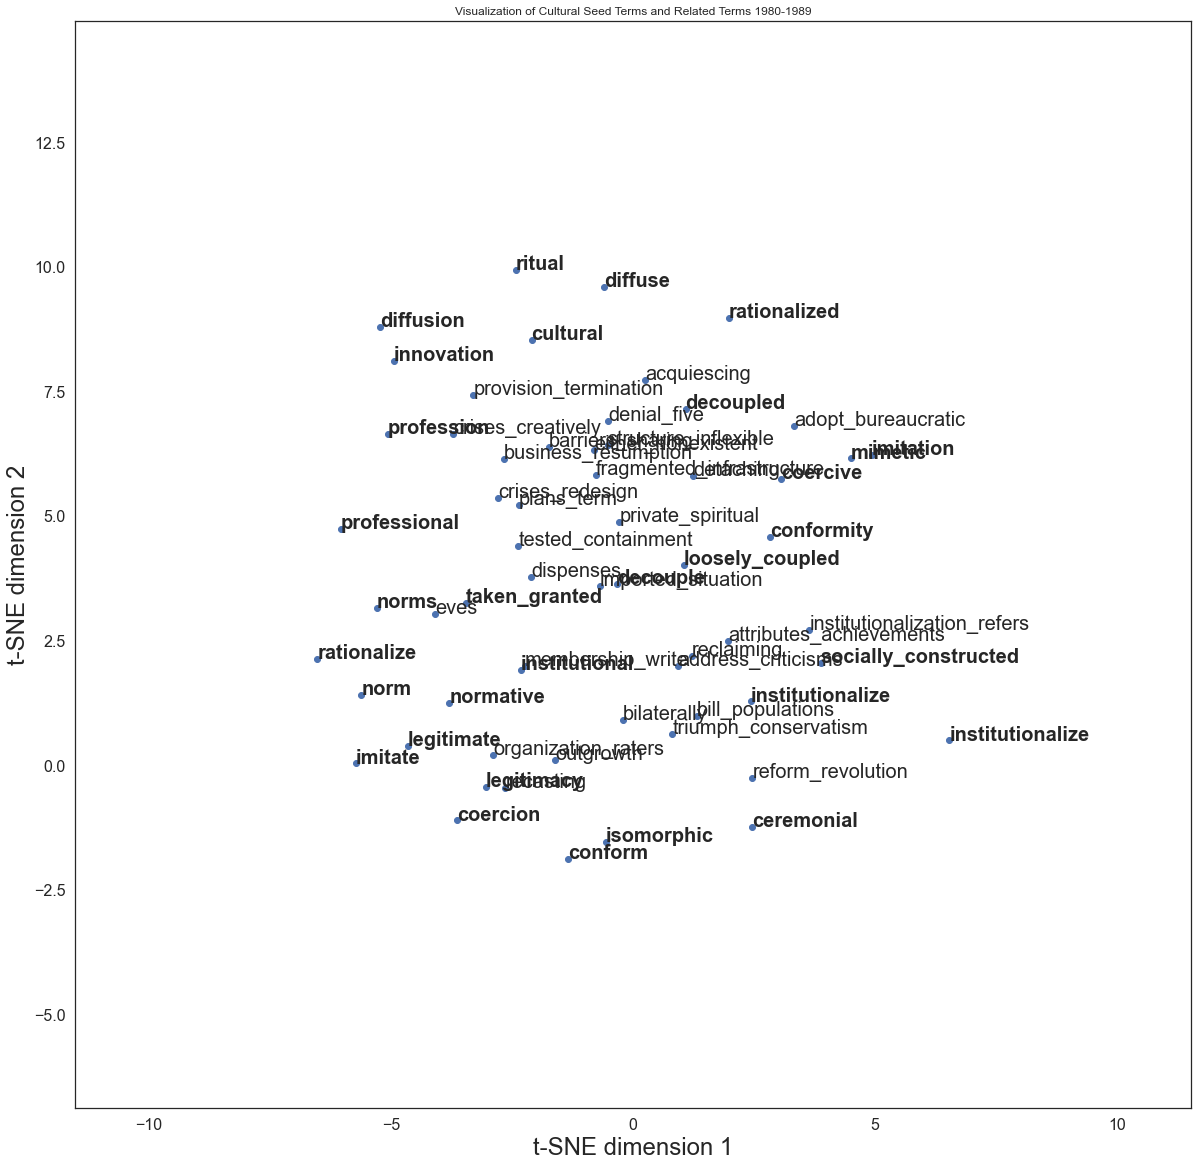

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


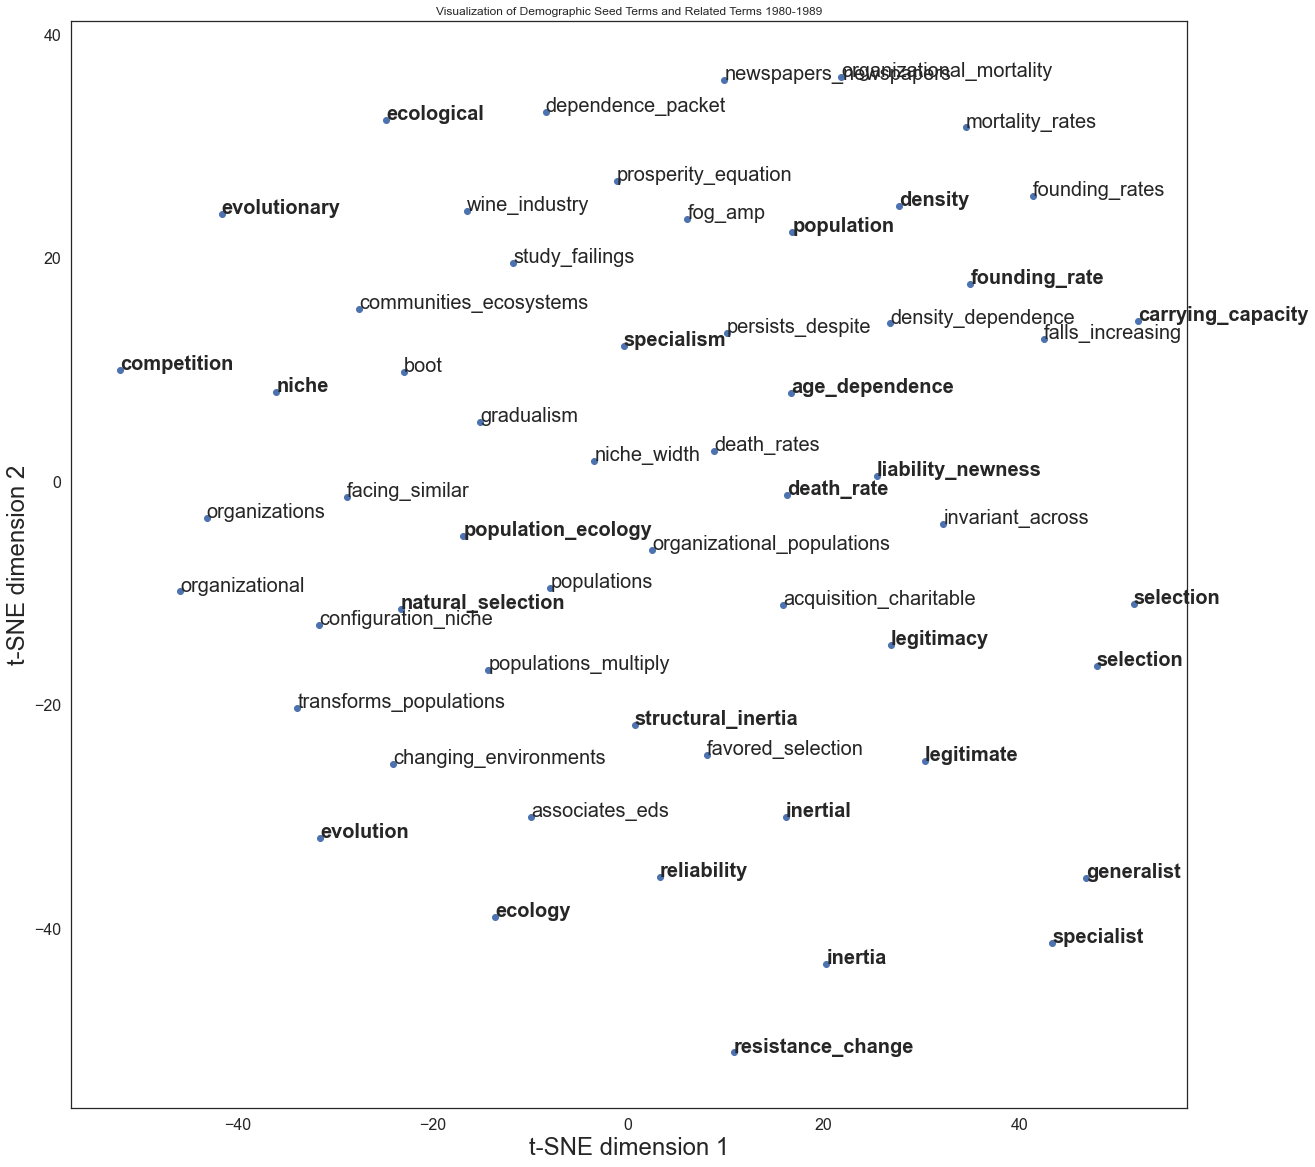

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


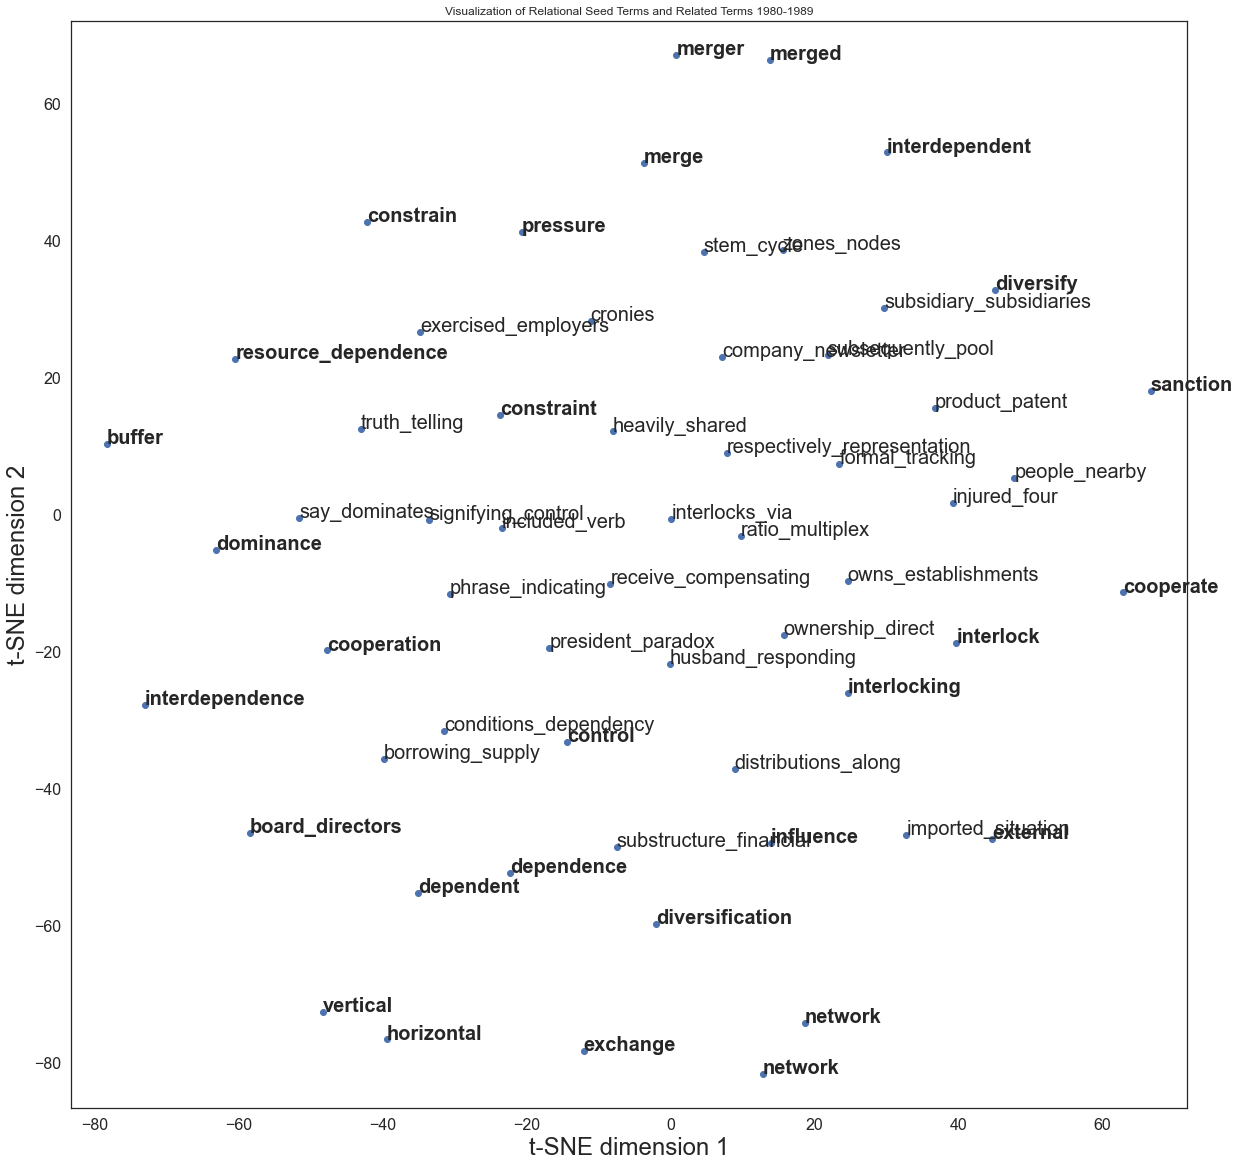

In [47]:
plot_tsne(cult_seed_lst2, cult_seed_lst2 + top_50_cult2[:30], m2, 'Cultural', '1980-1989')

plot_tsne(demog_seed_lst2, demog_seed_lst2 + top_50_demog2[:30], m2, 'Demographic', '1980-1989')

plot_tsne(rela_seed_lst2, rela_seed_lst2 + top_50_rela2[:30], m2, 'Relational', '1980-1989')




## 1990 - 1999

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


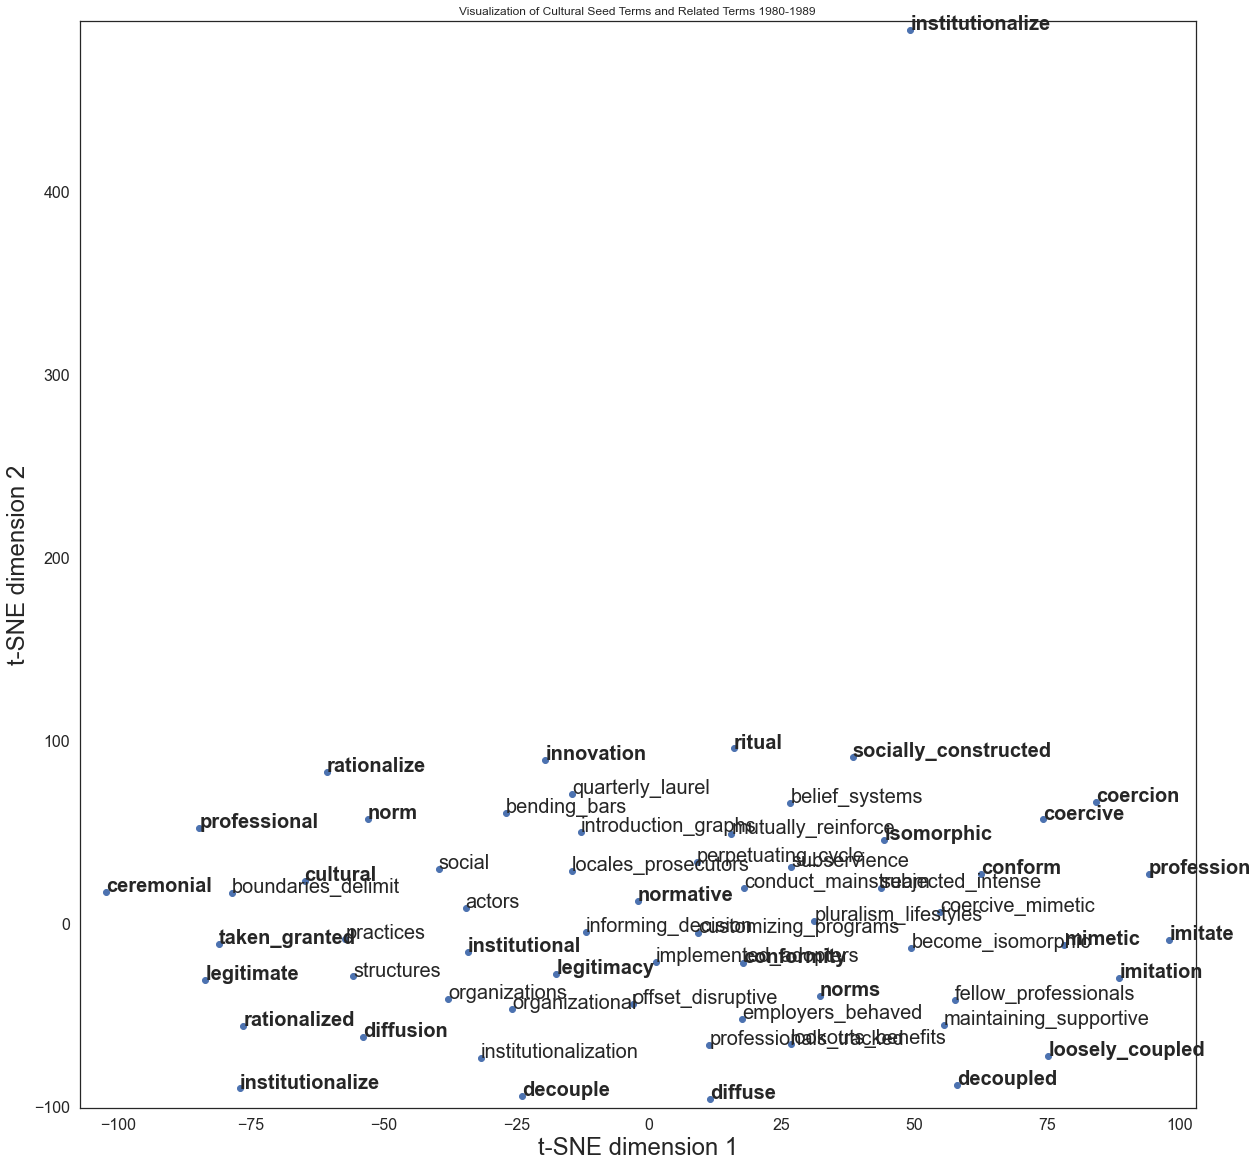

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


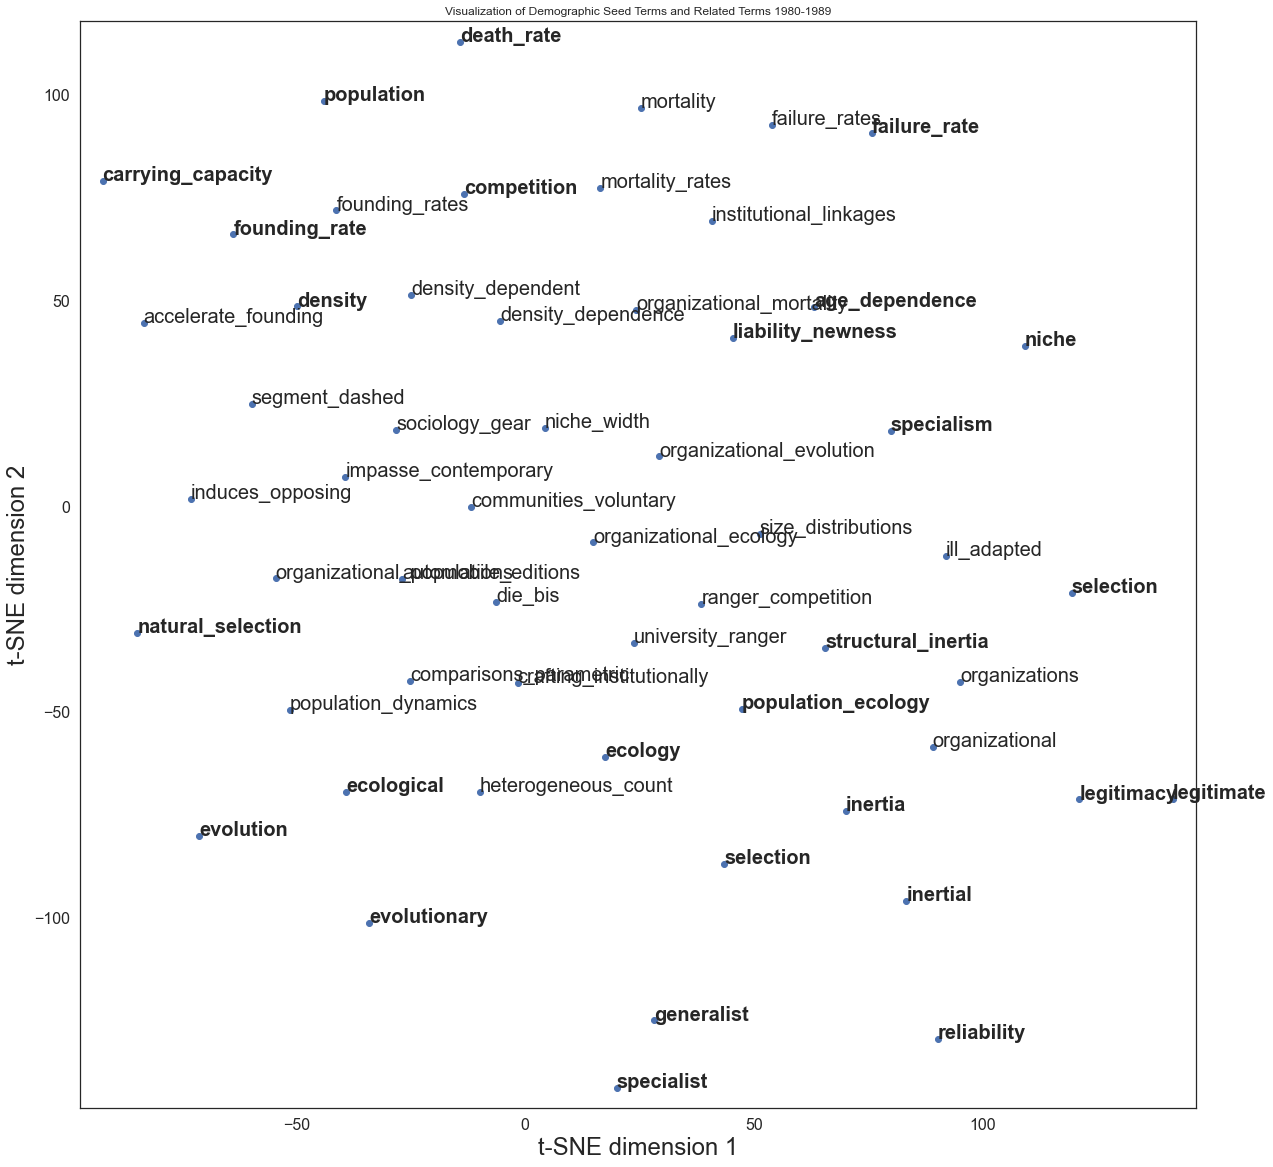

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


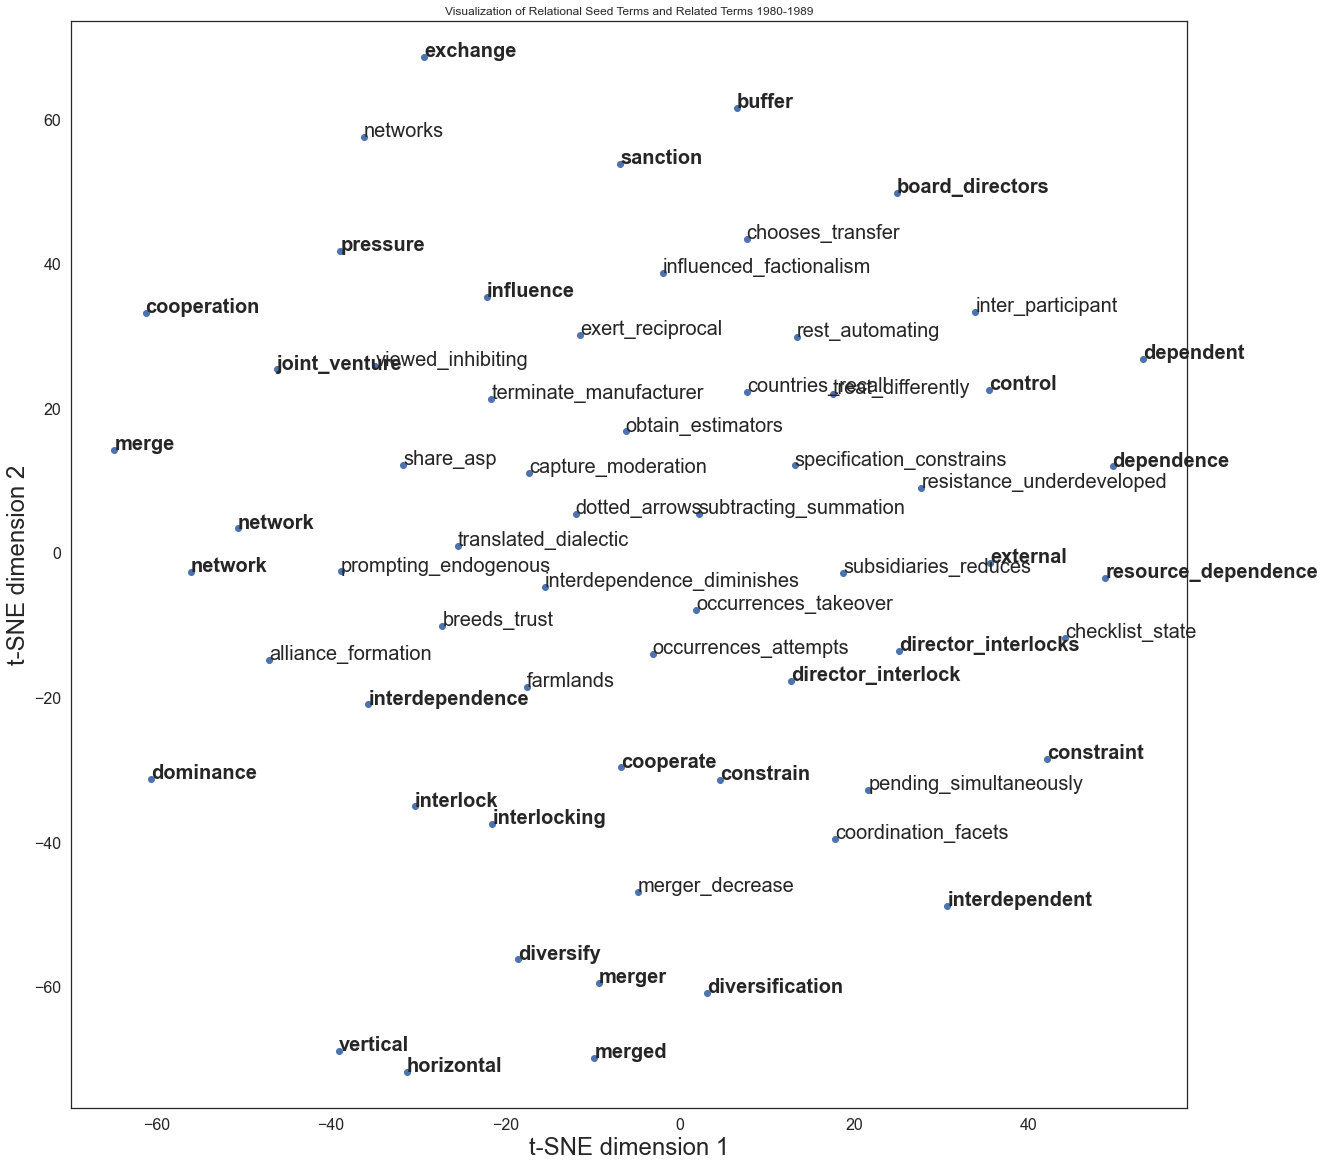

In [48]:
plot_tsne(cult_seed_lst3, cult_seed_lst3 + top_50_cult3[:30], m3, 'Cultural', '1980-1989')

plot_tsne(demog_seed_lst3, demog_seed_lst3 + top_50_demog3[:30], m3, 'Demographic', '1980-1989')

plot_tsne(rela_seed_lst3, rela_seed_lst3 + top_50_rela3[:30], m3, 'Relational', '1980-1989')




## 2000 - 2016

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


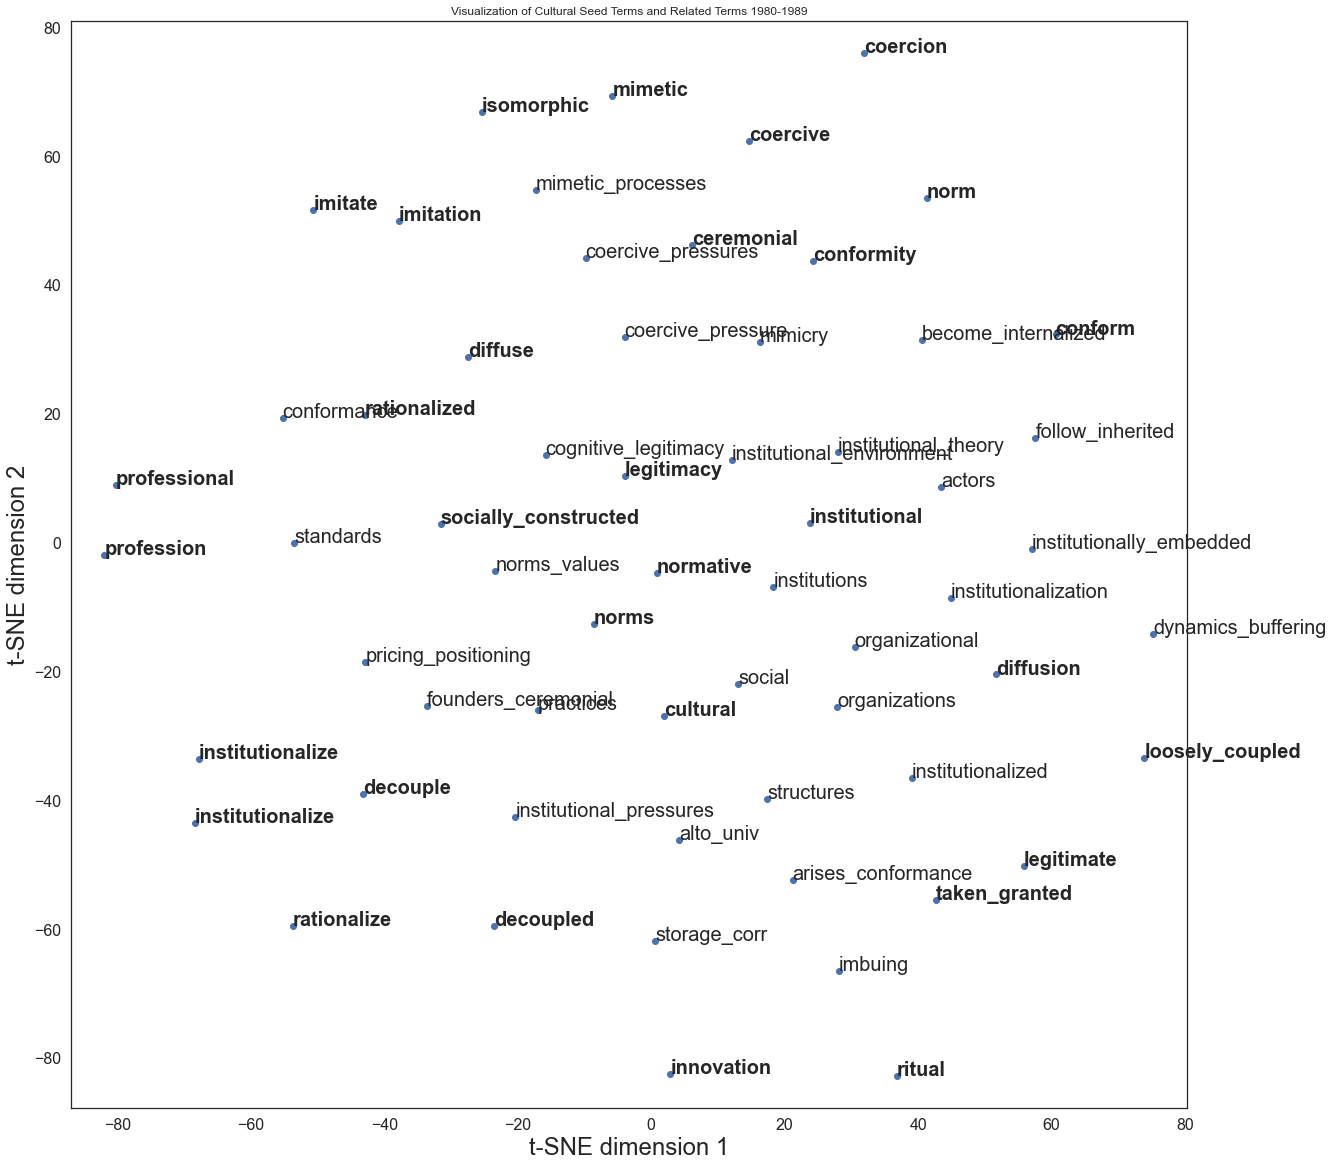

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


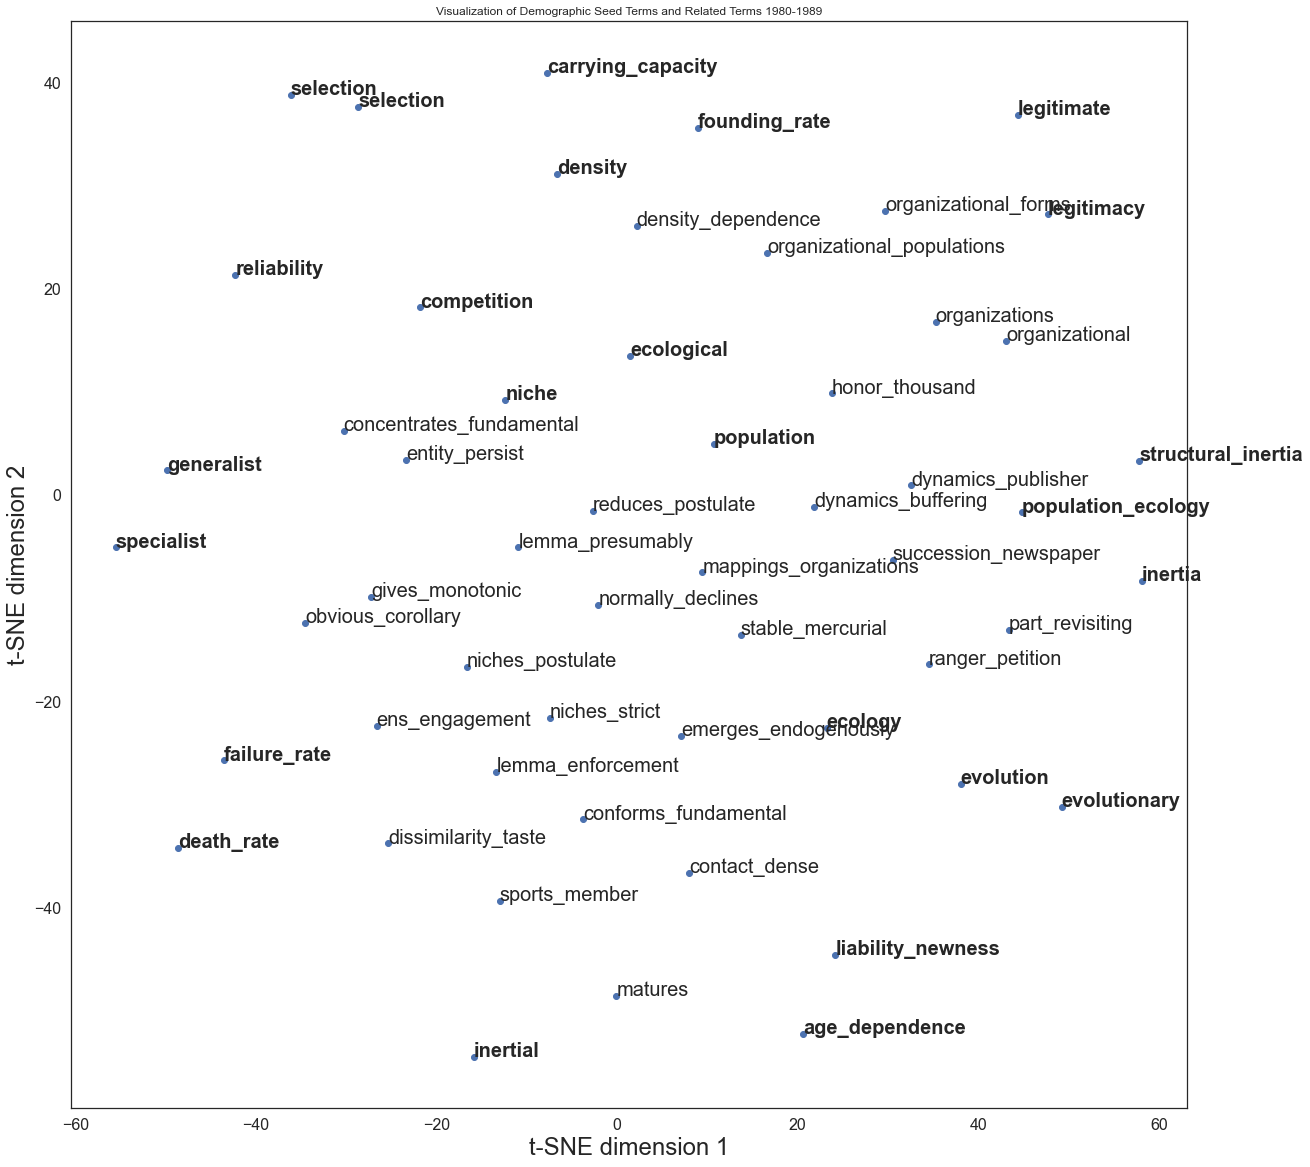

/Users/nancyxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


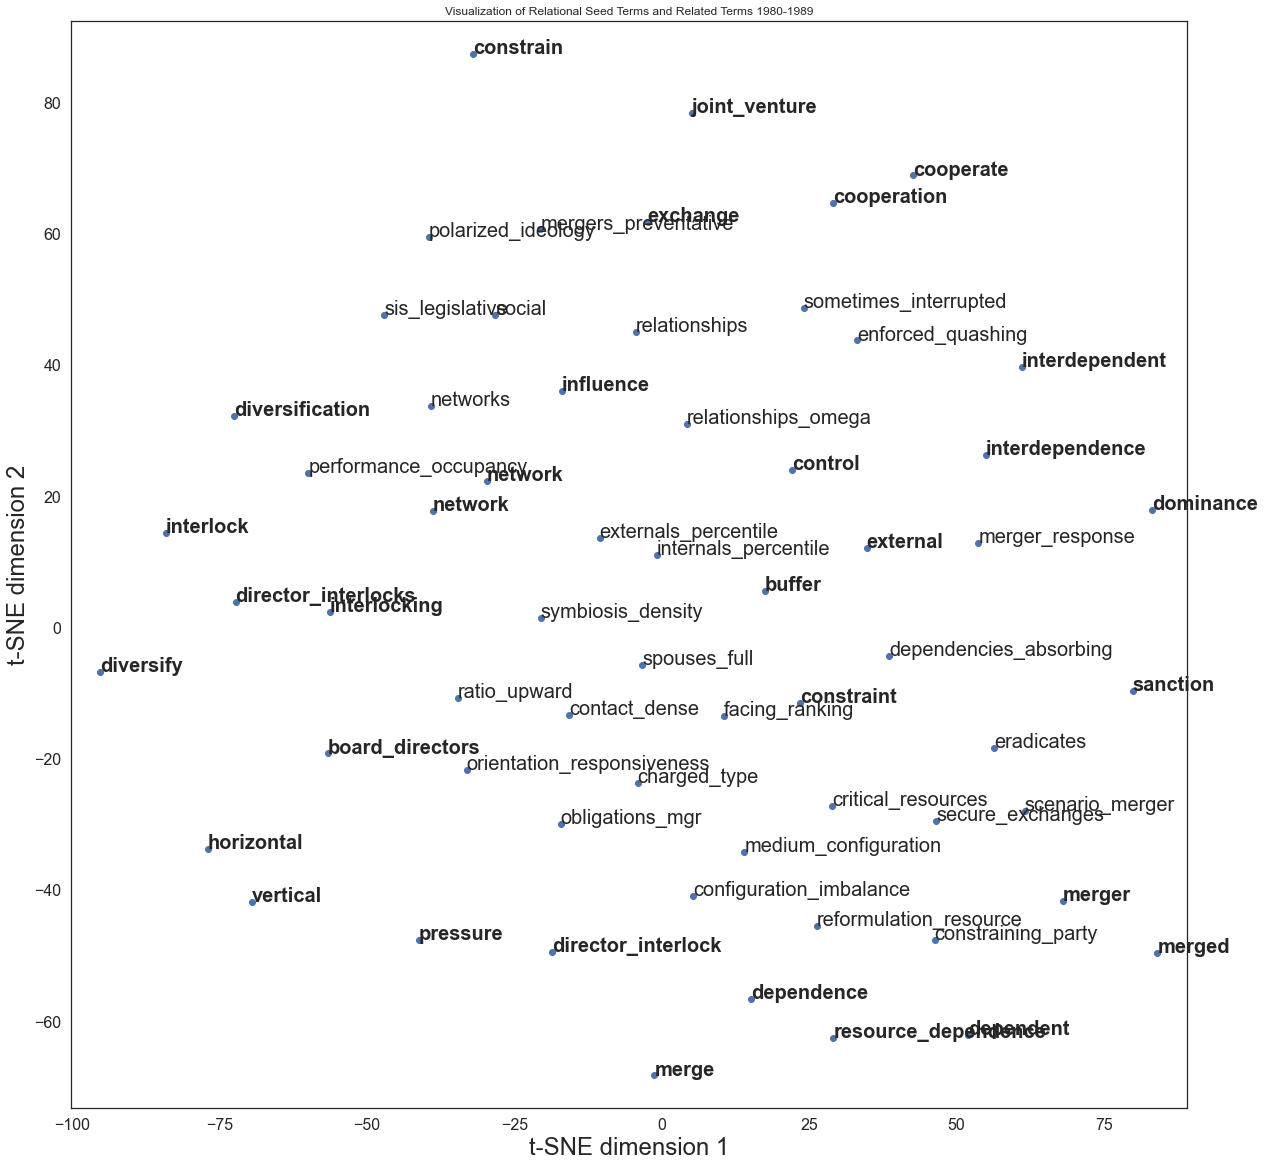

In [49]:
plot_tsne(cult_seed_lst4, cult_seed_lst4 + top_50_cult4[:30], m4, 'Cultural', '1980-1989')

plot_tsne(demog_seed_lst4, demog_seed_lst4 + top_50_demog4[:30], m4, 'Demographic', '1980-1989')

plot_tsne(rela_seed_lst4, rela_seed_lst4 + top_50_rela4[:30], m4, 'Relational', '1980-1989')


